In [1]:
import numpy as np
import numpy.matlib
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt

from __future__ import unicode_literals  # Only for python2.7 and save_as unicode filename
import pydicom
from pydicom.dataset import Dataset, FileDataset, FileMetaDataset
from pydicom.sequence import Sequence

C:\Users\tr17\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fcmrDir=r'E:\Users\tr17\Documents\Projects\PC_Fetal_CMR\Data\4D_Flow_Paper\fcmr202'

cineVolDir=r'\cine_vol'
cineVolniiFileName=r'\cine_vol.nii.gz'
cineVol_nii = nib.load(fcmrDir+cineVolDir+cineVolniiFileName)
cineVol_img = cineVol_nii.get_fdata()
print("Shape of cine_vol nifti:", cineVol_img.shape)

nX = cineVol_img.shape[0]
nY = cineVol_img.shape[1]
nZ = cineVol_img.shape[2]
nF = cineVol_img.shape[3]

dimX = cineVol_nii.header['pixdim'][1]
dimY = cineVol_nii.header['pixdim'][2]
dimZ = cineVol_nii.header['pixdim'][3]
dimF = cineVol_nii.header['pixdim'][4]
print("pixdim:", [dimX, dimY, dimZ, dimF])

c  = np.reshape(cineVol_img, [nX, nY, nZ*nF])
c[c==-1] = 0 # set background pixels = 0 (-1 in SVRTK)
c = c.astype("uint16") # convert to same datatype as DICOM
print("Shape of c:", c.shape)

Shape of cine_vol nifti: (43, 44, 52, 25)
pixdim: [1.25, 1.25, 1.25, 0.01714744]
Shape of c: (43, 44, 1300)


# Affine

In [3]:
a0 = cineVol_nii.affine[0,3]
a1 = cineVol_nii.affine[1,3]
a2 = cineVol_nii.affine[2,3]

print('Affine :', [a0, a1, a2])

Affine : [-36.181636810302734, 89.74490356445312, 32.812721252441406]


# Slice locations & indices

32.812721252441406 96.5627212524414 1300


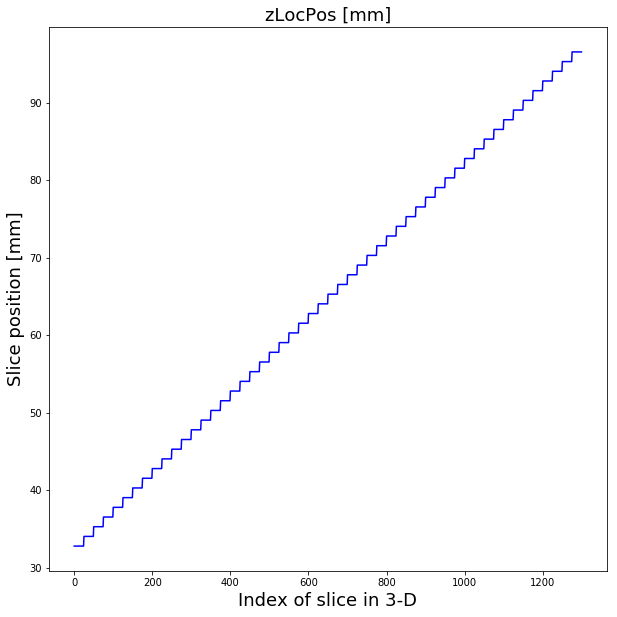

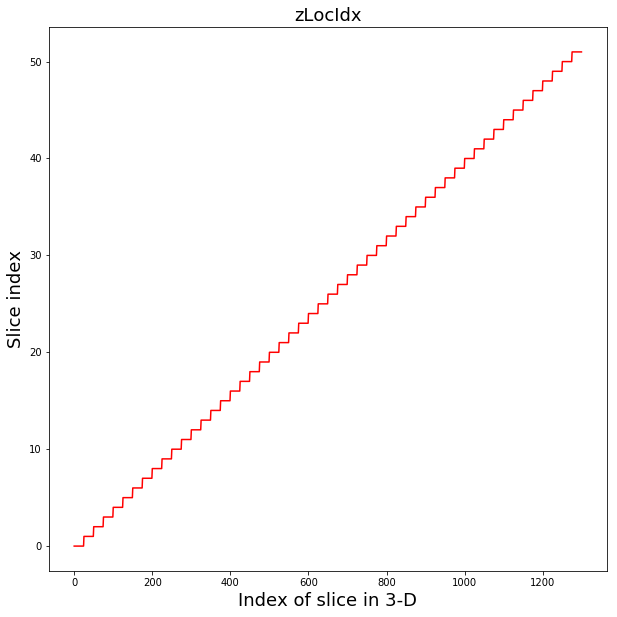

In [4]:
zLocFirst = 0 # TODO: incorporate nonzero starting point, i.e.: cineVol_nii.affine[2,3]
zLocFirst = a2
zLocLast = a2 + (dimZ * nZ) - dimZ
zLocPos = np.linspace(zLocFirst, zLocLast, num=nZ)
zLocPos = np.repeat(zLocPos, nF)

zLocIdx = np.zeros(nZ*nF)
for n in range(nZ*nF):
    zLocIdx[n] = np.floor(n/nF)

print(zLocFirst, zLocLast, len(zLocPos))

# zLocPos in [mm]
plt.figure(figsize=(10,10))
plt.plot(zLocPos,'-b')
plt.xlabel('Index of slice in 3-D', fontsize=18)
plt.ylabel('Slice position [mm]', fontsize=18)
plt.title('zLocPos [mm]', fontsize=18)
plt.show()

# zLoc indices
plt.figure(figsize=(10,10))
plt.plot(zLocIdx,'-r')
plt.xlabel('Index of slice in 3-D', fontsize=18)
plt.ylabel('Slice index', fontsize=18)
plt.title('zLocIdx', fontsize=18)
plt.show()

# Definitions

In [5]:
series_instance_unique_uid = pydicom.uid.generate_uid() # UID for dataset
instance_creator_unique_uid = pydicom.uid.generate_uid()
VERSION = 'v1.0.0'

import tempfile
suffix = 'tomTest.dcm'
filename_little_endian = tempfile.NamedTemporaryFile(suffix=suffix).name
filename_big_endian = tempfile.NamedTemporaryFile(suffix=suffix).name

In [6]:
for n in range(nZ*nF):
# for n in range(600,652):

    sop_instance_unique_uid = pydicom.uid.generate_uid()
    
    # File meta info data elements
    file_meta = FileMetaDataset()
    file_meta.FileMetaInformationGroupLength = 196                      # 210?
    file_meta.FileMetaInformationVersion = b'\x00\x01'                  # transfer from kt8 dicom?
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.4'     # xxx.7 = Secondary Capture Image Storage / xxx.4 = MR Image Storage
#     file_meta.MediaStorageSOPInstanceUID = series_instance_unique_uid   # identical to ds.SeriesInstanceUID in SVR code... 
    file_meta.MediaStorageSOPInstanceUID = sop_instance_unique_uid
    file_meta.TransferSyntaxUID = '1.2.840.10008.1.2'                   # transfer from kt8 dicom?
    file_meta.ImplementationClassUID = '1.2.276.0.7230010.3.0.3.6.1'    # transfer from kt8 dicom?
    file_meta.ImplementationVersionName = 'dicomserver ' + VERSION


    # SERIES REQUIRED FIELDS
    ds = Dataset()
#     ds = FileDataset(filename_little_endian, {}, file_meta=file_meta, preamble=b"\0" * 128)

    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4' # xxx.7 = Secondary Capture Image Storage / xxx.4 = MR Image Storage
    ds.SeriesInstanceUID = series_instance_unique_uid # consistent with file_meta
    ds.InstanceCreatorUID = instance_creator_unique_uid
    ds.SeriesNumber = 100 # update
    ds.BitsAllocated = 16
    ds.ImageOrientationPatient = ['1','0','0','0','1','0'] # think this = axial
    ds.PixelSpacing = [str(dimX),str(dimY)]
    ds.SpacingBetweenSlices = str(dimZ)
    ds.PatientName = '-*-'
    ds.PatientID = '*'
    ds.IssuerOfPatientID = ''
    ds.PatientBirthDate = ''

    # FRAME-WISE REQUIRED FIELDS
    # ds.SOPInstanceUID = sop_instance_unique_uid
    ds.SOPInstanceUID = pydicom.uid.generate_uid() # in SVR dicom code    
    ds.InstanceNumber = str(n)
    ds.SliceLocation = str(zLocPos[n])
    ds.ImagePositionPatient = [str(a0),str(a1),str(zLocPos[n])]
    
    # Write PixelData
    cToWrite = c[:,:,n]
    ds.PixelData = cToWrite.tobytes()
    ds.Rows = cToWrite.shape[0]
    ds.Columns = cToWrite.shape[1]

    # Create dicom
    ds.file_meta = file_meta
    ds.is_implicit_VR = True
    ds.is_little_endian = True
    ds.save_as(r'E:\Users\tr17\Documents\Projects\PC_Fetal_CMR\Data\dicom_fcmr_4d\dcm\dcmZtest\IM_%04d.dcm'%(n+1), write_like_original=False)

In [7]:
print(series_instance_unique_uid)
print(instance_creator_unique_uid)
print(sop_instance_unique_uid)
print(file_meta.MediaStorageSOPInstanceUID)
print(ds.SeriesInstanceUID)
print('Finished.')

1.2.826.0.1.3680043.8.498.91670844375253968649735811685608676690
1.2.826.0.1.3680043.8.498.13007571438147473823556772369387233753
1.2.826.0.1.3680043.8.498.40771155917086497432964880998479630657
1.2.826.0.1.3680043.8.498.70043963659657562713263118363514621145
1.2.826.0.1.3680043.8.498.91670844375253968649735811685608676690
Finished.


In [8]:
# Main data elements
# ds.SpecificCharacterSet = 'ISO_IR 100'
# ds.ImageType = ['ORIGINAL', 'PRIMARY', 'M_FFE', 'M', 'FFE']
# ds.InstanceCreationDate = '20120821'
# ds.InstanceCreationTime = '221700'
# ds.InstanceCreatorUID = '1.2.40.0.13.1.203399489339977079628124438700844270739'

# ds.SOPInstanceUID = '1.2.40.0.13.1.238698975124950281685715042764914485226' # below
# ds.StudyDate = '20120821'
# ds.SeriesDate = '20120821'
# ds.AcquisitionDate = '20120821'
# ds.ContentDate = '20120821'
# ds.StudyTime = '173207'
# ds.SeriesTime = '182511.32000'
# ds.AcquisitionTime = '182511.32'
# ds.ContentTime = '182511.32'
# ds.AccessionNumber = ''
# ds.Modality = 'MR'
# ds.Manufacturer = 'Philips Medical Systems'
# ds.CodeValue = ''
# ds.CodingSchemeDesignator = 'DCM'
# ds.CodeMeaning = ''

# ds.StudyInstanceUID = '1.2.40.0.13.1.333311361771566580913219583914625766216'
# ds.SeriesInstanceUID = '1.2.40.0.13.1.286595144572817015845933344548631223145'
# ds.StudyID = '513842.201207030'
# ds.SeriesNumber = "1006"
# ds.AcquisitionNumber = "10"
# ds.InstanceNumber = "329"
# ds.ImagePositionPatient = ['-58.266084007661', '-188.48125967922', '225.160076310167']
# ds.ImageOrientationPatient = ['0.51319164037704', '0.85772150754928', '-0.0307911429554', '-0.0599991045892', '6.4554493292E-05', '-0.9981984496116']
# ds.FrameOfReferenceUID = '1.2.40.0.13.1.168070265634523572089252568290704983898'
# ds.TemporalPositionIdentifier = "1"
# ds.NumberOfTemporalPositions = "1"
# ds.PositionReferenceIndicator = ''
# ds.SliceLocation = "41.5999958560011"
# ds.SamplesPerPixel = 1
# ds.PhotometricInterpretation = 'MONOCHROME2'
# ds.Rows = 192
# ds.Columns = 192
# ds.PixelSpacing = ['1.97916662693023', '1.97916662693023']


In [9]:
# ds.Format = 'DICOM'
# ds.FormatVersion = 3
# ds.BitDepth = 16 # assuming uint16 images

# ds.ConversionType = 'WSD' # WSD = Workstation
# ds.TimeofSecondaryCapture = ''
# ds.SecondaryCaptureDeviceManufacturer = 'PIH Research 4D FCMR Reconstruction'
# ds.SecondaryCaptureDeviceManufacturerModelName = '1.0.0'
# ds.SecondaryCaptureDeviceSoftwareVersion = '1.0.0'
